In [1]:
import torch
import clip
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device: ', device)
model, preprocess = clip.load("ViT-B/32", device=device)
print('Finished loading model')

Using device:  cuda
Finished loading model


In [3]:
# def compute_similarity(query, frame):
#     # Convert opencv frame to PIL image (what CLIP uses)
#     pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#     image = preprocess(pil_image).unsqueeze(0).to(device)
#     text = clip.tokenize([query]).to(device)

#     with torch.no_grad():
#         image_features = model.encode_image(image)
#         text_features = model.encode_text(text)

#         logits_per_image, logits_per_text = model(image, text)
#         probs = logits_per_image.softmax(dim=-1).cpu().numpy()
#         probs = np.around(probs, decimals=4)

#         # Compute similarity using dot product
#         dot = (100.0 * image_features @ text_features.T).cpu().squeeze()
#         similarity = dot / np.linalg.norm(image_features.cpu(), axis=1) * np.linalg.norm(text_features.cpu())
#         similarity = np.dot(image_features.cpu(), text_features.cpu().T) / (np.linalg.norm(image_features.cpu(), axis=1) * np.linalg.norm(text_features.cpu()))

#     return similarity

def compute_similarity(query, frame):
    # Convert opencv frame to PIL image (what CLIP uses)
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image = preprocess(pil_image).unsqueeze(0).to(device)
    text = clip.tokenize([query]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1)

        # Compute similarity using dot product
        dot = (100.0 * image_features @ text_features.T).squeeze()
        similarity = dot / (image_features.norm(dim=1) * text_features.norm(dim=1))

    return similarity.cpu().numpy()



In [4]:
def find_matched_frames(filename, query, similarity_threshold):
    cap = cv2.VideoCapture(filename)
    matched_frames = []

    frame_index = 0
    while True:
        ret, frame = cap.read()
        if not ret: # haven't reached the end yet
            break

        # Compute similarity
#         print(f'On frame: {frame_index}')
        similarity = compute_similarity(query, frame)

        if similarity > similarity_threshold:
            # print(f'Similarity {similarity} - match')
            matched_frames.append((frame_index, similarity.item()))
        else:
            matched_frames.append((frame_index, similarity.item()))

            # print(f'Similarity {similarity} - no match')
            pass
        frame_index += 1
        print(f"Frame number {frame_index}/105", end="\r", flush=True)

    print('num frames: ', frame_index + 1)
    cap.release() # Release resources
    return matched_frames


In [5]:
# Load video frames
video = 'giraffe_and_hippo.mp4'
query = 'a giraffe'

# hippo: 15 to 87
# giraffe


In [6]:
# Get frames
matched_frames = find_matched_frames(video, query, similarity_threshold=2200)
x = [t[0] for t in matched_frames]
y = [t[1] for t in matched_frames]


num frames:  105/105


In [7]:
# Compute statistical measures
mean = np.mean(y)
range_ = np.ptp(y)
std_dev = np.std(y)
min_val = np.min(y)
max_val = np.max(y)


In [8]:
# Print the results
print(f'Mean: {mean}')
print(f'Range: {range_}')
print(f'Standard deviation: {std_dev}')
print(f'Minimum value: {min_val}')
print(f'Maximum value: {max_val}')


Mean: 22.464693509615383
Range: 13.671875
Standard deviation: 5.57737753354627
Minimum value: 17.484375
Maximum value: 31.15625


In [42]:
# Sample data
data = np.array(y).reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
print(f'Distance between centroids: {abs(centroids[0] - centroids[1])}')


C:\Users\david\anaconda3\envs\gpu_env2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\david\anaconda3\envs\gpu_env2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Distance between centroids: [12.06582109]


In [43]:
# Calculate silhouette score
silhouette_avg = silhouette_score(data, kmeans.labels_)
print(f'Silhouette average: {silhouette_avg}')

# Print the result
if silhouette_avg < 0.2:
    print("Warning: low silhouette score indicates poor clustering")


Silhouette average: 0.9328710196441841


In [60]:
# Generate some sample data
X = data

# Define the range of cluster sizes to test
min_clusters = 2
max_clusters = 10
cluster_range = range(min_clusters, max_clusters+1)

# Compute the average silhouette score for each cluster size
avg_scores = []
for n_clusters in cluster_range:
    # Fit the clustering algorithm to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    # Compute the silhouette score for each point
    silhouette_vals = silhouette_score(X, labels)

    # Compute the average silhouette score for all points
    avg_score = silhouette_vals.mean()
    avg_scores.append(avg_score)

# Find the optimal number of clusters based on the highest average silhouette score
optimal_n_clusters = cluster_range[np.argmax(avg_scores)]
print(avg_scores)
print(f"The optimal number of clusters is {optimal_n_clusters}")


C:\Users\david\anaconda3\envs\gpu_env2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\david\anaconda3\envs\gpu_env2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\david\anaconda3\envs\gpu_env2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\david\anaconda3\envs\gpu_env2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: User

[0.9328710196441841, 0.7531026149400013, 0.7481545110545039, 0.7392102513846104, 0.7050388790849608, 0.7053939524317829, 0.7078116197726954, 0.6973405580538793, 0.5823172415787615]
The optimal number of clusters is 2


In [45]:
from sklearn.cluster import DBSCAN

def find_optimal_num_clusters(X):
    scores = []
    eps_values = np.linspace(0.1, 5, 50)
    
    # Compute silhouette score for different values of eps
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps)
        labels_ = dbscan.fit_predict(X)
        
        # If all points are assigned to one cluster, skip silhouette score calculation
        if len(set(labels_)) == 1:
            scores.append(-1)
            continue
            
        score = silhouette_score(X, labels)
        scores.append(score)
    
    # Determine optimal number of clusters based on the maximum silhouette score
    print(scores)
    max_score = max(scores)
    if max_score == -1:
        optimal_num_clusters = 1
    else:
        optimal_eps = eps_values[np.argmax(scores)]
        print(optimal_eps)
        dbscan = DBSCAN(eps=optimal_eps, min_samples=2)
        labels_ = dbscan.fit_predict(X)
        optimal_num_clusters = len(np.unique(labels_)) - (1 if -1 in labels_ else 0)
    
    return optimal_num_clusters

print(f'DBSCAN optimal number of clusters: {find_optimal_num_clusters(data)}')


[0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615, 0.5823172415787615]

In [46]:
def compute_optimal_num_clusters(X, min_samples):
    eps_values = np.linspace(0.1, 5, 50)
    silhouette_scores = []
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels_ = dbscan.fit_predict(X)
        if len(np.unique(labels_)) == 1:
            silhouette_scores.append(-1)
        else:
            silhouette_scores.append(silhouette_score(X, labels_))
    max_silhouette_score = max(silhouette_scores)
    if max_silhouette_score == -1:
        return 1
    else:
        optimal_eps = eps_values[silhouette_scores.index(max_silhouette_score)]
        print(f'Optimal eps: {optimal_eps}')
        optimal_eps = 0.4
        dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
        labels_ = dbscan.fit_predict(X)
        num_clusters = len(np.unique(labels_)) - (1 if -1 in labels_ else 0)
        return num_clusters
print(f'DBSCAN2 optimal number of clusters: {compute_optimal_num_clusters(data,2)}')


Optimal eps: 0.30000000000000004
DBSCAN2 optimal number of clusters: 2


In [47]:
# Run k-means with a range of cluster numbers
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)


C:\Users\david\anaconda3\envs\gpu_env2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\david\anaconda3\envs\gpu_env2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\david\anaconda3\envs\gpu_env2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\david\anaconda3\envs\gpu_env2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: User

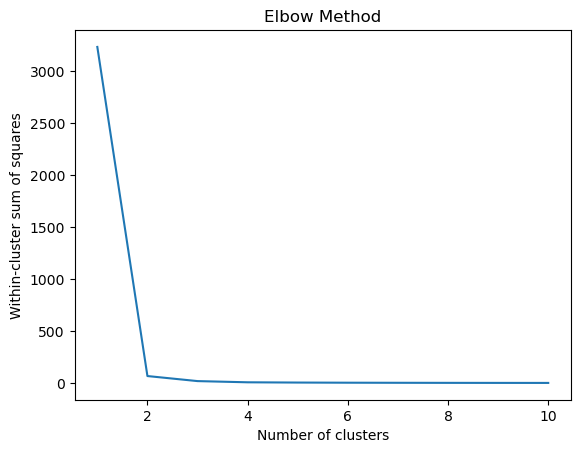

In [48]:
# Plot the within-cluster sum of squares as a function of the number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.show()


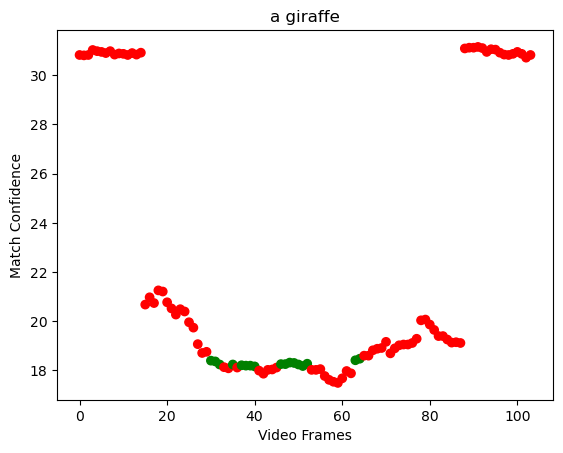

In [49]:
# Compute cluster that represents matches
match_cluster = 0 if centroids[0] > centroids[1] else 1

colors = ['g' if labels[i] == match_cluster else 'r' for i in range(len(y))]

# Create the plot with the colored data points
plt.scatter(range(len(y)), y, c=colors)

# Set the x and y axis labels
plt.xlabel('Video Frames')
plt.ylabel('Match Confidence')
plt.title(query)

# Show the plot
plt.show()


In [61]:
dbscan = DBSCAN(eps=2, min_samples=2)
labels = dbscan.fit_predict(X)

In [51]:
print(len(labels), labels, labels.shape)

104 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (104,)


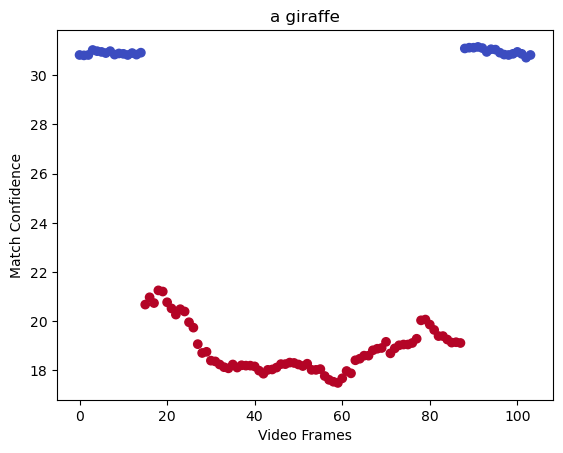

In [52]:
dbscan = DBSCAN(eps=2, min_samples=2)
labels = dbscan.fit_predict(X)

# Compute cluster that represents matches
# match_cluster = 0 if centroids[0] > centroids[1] else 1
unique_labels = list(set(labels))
label_colors = {label: color for label, color in zip(unique_labels, plt.cm.coolwarm(np.linspace(0, 1, len(unique_labels))))}
colors = [label_colors[label] for label in labels]

# Create the plot with the colored data points
plt.scatter(range(len(y)), y, c=colors)

# Set the x and y axis labels
plt.xlabel('Video Frames')
plt.ylabel('Match Confidence')
plt.title(query)

# Show the plot
plt.show()


In [87]:
def cluster_similar_frames(similarities, method='dbscan'):
    if method == 'dbscan':
        # Run DBSCAN
        dbscan = DBSCAN(eps=2, min_samples=2)
        # Labels are 0 to #clusters-1
        labels = dbscan.fit_predict(similarities)

        # For now on, we want similarities to be standard np array
        similarities = similarities.reshape((-1,))

        accuracy_classes = []
        for label in range(len(set(labels))):
            frame_indices_in_acc_class = [(i,) for i in range(len(similarities)) if labels[i] == label]
            avg_acc_in_class = np.take(similarities, frame_indices_in_acc_class).mean()
            
            print(f'{avg_acc_in_class}:  {str(frame_indices_in_acc_class)}')
            accuracy_classes.append((avg_acc_in_class, frame_indices_in_acc_class))
        return accuracy_classes
accuracy_classes = cluster_similar_frames(X)
print(accuracy_classes)

30.933971774193548:  [(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (88,), (89,), (90,), (91,), (92,), (93,), (94,), (95,), (96,), (97,), (98,), (99,), (100,), (101,), (102,), (103,)]
18.868150684931507:  [(15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (27,), (28,), (29,), (30,), (31,), (32,), (33,), (34,), (35,), (36,), (37,), (38,), (39,), (40,), (41,), (42,), (43,), (44,), (45,), (46,), (47,), (48,), (49,), (50,), (51,), (52,), (53,), (54,), (55,), (56,), (57,), (58,), (59,), (60,), (61,), (62,), (63,), (64,), (65,), (66,), (67,), (68,), (69,), (70,), (71,), (72,), (73,), (74,), (75,), (76,), (77,), (78,), (79,), (80,), (81,), (82,), (83,), (84,), (85,), (86,), (87,)]
[(30.933971774193548, [(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (88,), (89,), (90,), (91,), (92,), (93,), (94,), (95,), (96,), (97,), (98,), (99,), (100,), (101,), (102,), (103,)])

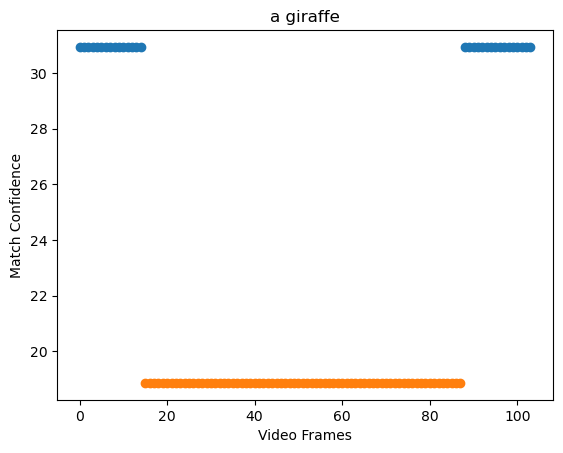

In [88]:

# Set up the figure
fig, ax = plt.subplots()

# Plot each array of ints as points in a different color
for i, (x, y) in enumerate(accuracy_classes):
    ax.scatter(y, x * np.ones_like(y), c=f'C{i}')

# Set the x and y axis labels
plt.xlabel('Video Frames')
plt.ylabel('Match Confidence')
plt.title(query)

# Show the plot
plt.show()

In [99]:
def merge_contiguous_tuples(arr):
    merged_arr = []
    for tup in arr:
        if not merged_arr or tup[0] > merged_arr[-1][1] + 1:
            merged_arr.append(tup)
        else:
            merged_arr[-1] = (merged_arr[-1][0], max(merged_arr[-1][1], tup[1]))
    return merged_arr
print(merge_contiguous_tuples([(1, 2), (3, 4), (5, 7), (8, 10), (14, 14),(15,17)]))

[(1, 10), (14, 17)]


In [102]:
def merge_contiguous_intervals(accuracy_classes):
    new_acc_classes = []
    for (acc, intervals) in accuracy_classes:
        intervals = [(x,x) for (x,) in intervals] # DELETE!!!
        merged_intervals = merge_contiguous_tuples(intervals)
        new_acc_classes.append((acc, merged_intervals))
    return new_acc_classes
print(merge_contiguous_intervals(accuracy_classes))

[(30.933971774193548, [(0, 14), (88, 103)]), (18.868150684931507, [(15, 87)])]


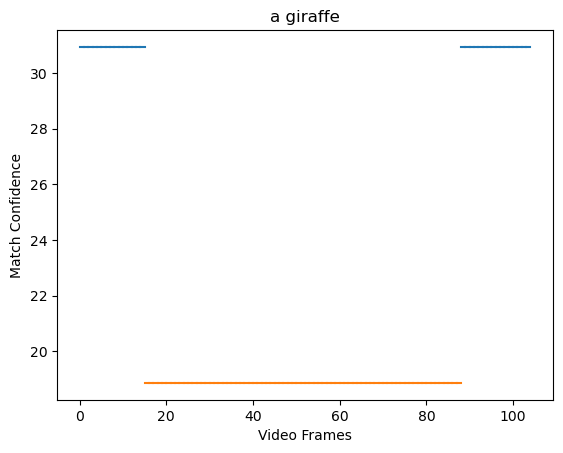

In [112]:
# Set up the figure
fig, ax = plt.subplots()

# Plot each array of ints as lines in a different color
for i, (x, y) in enumerate(accuracy_classes):
    for segment in y:
        if len(segment) == 2:
            start, end = segment
        else:
            start, end = segment[0], segment[0]+1
        ax.plot([start, end], [x, x], c=f'C{i}')

# Set the x and y axis labels
plt.xlabel('Video Frames')
plt.ylabel('Match Confidence')
plt.title(query)

# Show the plot
plt.show()
